## AutoCoT implementation

AutoCoT configured for huggingface gsm8k dataset but can be easily adpoted to any other huggingface dataset

Install all libraries and get dataset

In [136]:
!pip3 install openai
!pip3 install python-dotenv
!pip3 install sentence-transformers
!pip3 install joblib

from transformers import AutoTokenizer
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.
import os
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import Dataset, load_dataset
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import collections
import evaluate
from tqdm.auto import tqdm

import joblib
import json
import re

import random
import numpy as np
import torch

def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

dataset = load_dataset("gsm8k", "main")

Initialize chatgptapi and questions

In [137]:
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY")
)
encoder = SentenceTransformer("all-MiniLM-L6-v2")

questions = []
for inx, q in enumerate(dataset["test"]["question"]):
    questions.append(q)

Run clustering of questions

c:\Users\Austin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Austin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In a certain school, two classes have a total of 80 students. Each class has the same amount of students, and in each class 40% of the students are girls. How many boys are in each class?
: 1. Since there are 80 students in total and each class has the same amount of students, there are 40 students in each class. 2. Given that 40% of the students are girls in each class, we can calculate the number of girls in each class: 40% of 40 students = 0.40 * 40 = 16 girls in each class 3. Since we know that each class has the same number of boys, we can now calculate the number of boys in each class: Total students in each class = 40 Girls in each class = 16 Boys in each class = Total students - Girls in each class Boys in each class = 40 - 16 = 24 Therefore, there are 24 boys in each class.
24
None

Cindy's math and science books weigh 2 pounds each.  Her French book weighs 4 pounds and her English book weighs 3 pounds.  Her history book weighs twice as much as her English book.  If Cindy carr

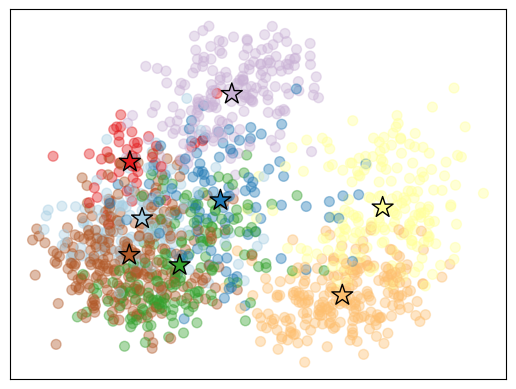

In [138]:
corpus_embeddings = encoder.encode(questions)
fix_seed(192)
clustering_model = KMeans(n_clusters=8, random_state=192)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

# # write results into file
# with open('clustered_questions_gsm8ktrain.json', 'w') as file:
#     json.dump(cluster_assignment.tolist(), file)

# # Reading from file
# with open('array_data.json', 'r') as file:
#     loaded_array = json.load(file)

dist = clustering_model.transform(corpus_embeddings)

# Store model for fast usage
# joblib.dump(clustering_model, 'clustering_model.pkl')
# Load model
# loaded_model = joblib.load('clustering_model.pkl')

clustered_dists = [[] for i in range(8)]
clustered_idx = [[] for i in range(8)]
clustered_sentences = [[] for i in range(8)]
from sklearn.decomposition import PCA

for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(questions[sentence_id])
    clustered_dists[cluster_id].append(dist[sentence_id][cluster_id])
    clustered_idx[cluster_id].append(sentence_id)


y_km = clustering_model.fit_predict(corpus_embeddings)
pca_model = PCA(n_components=2, random_state=192)
transformed = pca_model.fit_transform(corpus_embeddings)
centers = pca_model.transform(clustering_model.cluster_centers_)

plt.scatter(x=transformed[:, 0], y=transformed[:, 1], c=y_km, s=50, cmap=plt.cm.Paired, alpha=0.4)
plt.scatter(centers[:, 0],centers[:, 1],
        s=250, marker='*', label='centroids',
        edgecolor='black',
        c=np.arange(0,8),cmap=plt.cm.Paired,)
plt.xticks([])
plt.yticks([])
plt.savefig("clustering.png", dpi=600)

def extract_answers():
    a = []

    for _, ans in enumerate(dataset["test"]["answer"]):
        answer = ans.split("####")[-1].strip()
        a.append(answer)

    return a

def preprocess_rationale(r):
    cleaned_rationale = r.replace("\n\n", "\n").replace("\n", " ").replace(" Step", ". Step")
    while cleaned_rationale[0] == "." or cleaned_rationale[0] == " ":
        cleaned_rationale = cleaned_rationale[1:]

    return cleaned_rationale

def generate_rationale(q):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": "Q: " + q + "\nA: Let's think step by step",
            }
        ],
        model="gpt-3.5-turbo",
    )

    return chat_completion.choices[0].message.content

demos = []
answers = extract_answers()

for i in range(len(clustered_dists)):
    tmp = list(map(list, zip(range(len(clustered_dists[i])), clustered_dists[i])))
    top_min_dist = sorted(tmp, key=lambda x: x[1], reverse=False)

    for element in top_min_dist:
        min_idx = element[0]
        c_rationale = generate_rationale(questions[clustered_idx[i][min_idx]])
        # print("rationale", c_rationale, c_rationale.replace("\n\n", "\n").split("\n"), len(questions[clustered_idx[i][min_idx]].strip().split()))
        c_pred_ans = answers[clustered_idx[i][min_idx]].strip()
        if len(questions[clustered_idx[i][min_idx]].strip().split()) <= 120 \
            and len(c_rationale.replace("\n\n", "\n").split("\n")) <= 50 and c_pred_ans != "":
            if c_pred_ans not in c_rationale:
                 continue
            # if True:
            #     if not (c_pred_ans.strip() in c_rationale.split(".")[-2] or c_pred_ans.strip() in c_rationale.split()[-10:]):
            #         print("here2")
            #         continue
            c_question = questions[clustered_idx[i][min_idx]]
            
            c_rationale = preprocess_rationale(c_rationale)
            # c_rationale = c_rationale.replace("\n\n", "\n").replace("\n", " ").strip()
            # c_rationale = " ".join(c_rationale.split())
            if False:
                c_gold_ans = gold_ans[clustered_idx[i][min_idx]]
            else:
                c_gold_ans = None
            demo_element = {
                "question": c_question,
                "rationale": c_rationale,
                "pred_ans": c_pred_ans,
                "gold_ans": c_gold_ans,
            }
            demos.append(demo_element)
            # print(c_question)
            # print(c_rationale)
            # print(c_pred_ans)
            # print(c_gold_ans)
            # print("")
            break


with open("generated demos", 'w', encoding="utf-8") as write_f:
        json.dump(demos, write_f, indent=4, ensure_ascii=False)

Create demo text and use it for validation

In [139]:
def create_demo_text():
    x, z, y = [], [], []
    
    with open("generated demos", encoding="utf-8") as f:
        json_data = json.load(f)
        # json_data = json_data["demo"]
        for line in json_data:
            x.append(line["question"])
            z.append(line["rationale"])
            y.append(line["pred_ans"])

    index_list = list(range(len(x)))
    
    demo_text = ""
    for i in index_list:
        demo_text += x[i] + " " + z[i] + " The answer is " + y[i] + ".\n\n"

    return demo_text

demo = create_demo_text()
number_of_demos = 2
test_demo = demo.split("\n\n")[:number_of_demos]
character_for_join = "\n\n"
test_demo = character_for_join.join(test_demo) + "\n\n"

def clean_answer_get_ans(answer, id):
    while "<<" in answer:
        start = answer.index("<<")
        i = answer.index(">>")
        end_inx = i + 2
        # while test_context[end_inx].isnumeric() or (test_context[end_inx] == "." and test_context[end_inx + 1].isnumeric()):
        #     end_inx += 1
        
        answer = answer[:start] + answer[end_inx:]

    answer = answer.replace(" = ", "=").replace("=", " = ")

    ans = answer.split("####")[-1].strip()
    assert len(ans) > 0
    answer = answer.split("####")[0]
    answer = answer.replace("\n\n", "\n").replace("\n", " ")
    answer = answer.rstrip()
    answer_start_indices = [m.start() for m in re.finditer(ans, answer)]
    if len(answer_start_indices) < 1:
        return None
    assert len(answer_start_indices) > 0

    # text, answer_start
    result_ans = []
    for _ in answer_start_indices:
        result_ans.append(ans)

    return {
        "text": result_ans,
        "answer_start": answer_start_indices
    }

def clean_rationale(ra):
    answer = ra
    while "<<" in answer:
        start = answer.index("<<")
        i = answer.index(">>")
        end_inx = i + 2
        # while test_context[end_inx].isnumeric() or (test_context[end_inx] == "." and test_context[end_inx + 1].isnumeric()):
        #     end_inx += 1
        
        answer = answer[:start] + answer[end_inx:]

    answer = answer.replace(" = ", "=").replace("=", " = ")
    answer = answer.split("####")[0]
    return answer.replace("\n\n", "\n").replace("\n", " ").rstrip()

trained_checkpoint = "distilbert-base-cased-distilled-squad"
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

max_length_for_context_span = 512
stride = 200

demo = create_demo_text()

apply_cot = False

def preprocess_validation_examples(examples):
    questions = []
    if apply_cot:
        questions = [(test_demo + "Q: " + q.strip() + "\n" + "A: Let's think step by step") for q in examples["questions"]]
    else:
        questions = [q.strip() for q in examples["questions"]]
        
    # questions = [(demo + "Q: " + q.strip() + "\n" + "A: Let's think step by step") for q in examples["questions"]]
    inputs = bert_tokenizer(
        questions,
        examples["contexts"],
        max_length=max_length_for_context_span,
        truncation=True,
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

ids = []
questions = []
contexts = []
answers = []

def extract_answers_validation():
    a = []

    for indx, ans in enumerate(dataset["test"]["answer"]):
        answer = ans.split("####")[-1].strip()
        a.append(answer)

    return a

# answers = extract_answers_validation()

for inx, itm in enumerate(dataset["test"]):
    processed_answer = clean_answer_get_ans(itm["answer"], inx)
    if processed_answer == None:
        continue
    questions.append(itm["question"])
    ids.append(inx)
    processed_context = clean_rationale(itm["answer"])
    contexts.append(processed_context)
    answers.append(processed_answer)

assert len(ids) == len(questions) == len(contexts) == len(answers)


validation_ds = Dataset.from_dict({"id": ids, "questions": questions, "contexts": contexts, "answers": answers})

for indx, vd_itm in enumerate(validation_ds):
    assert len(validation_ds[indx]["answers"]["text"]) > 0 and len(validation_ds[indx]["answers"]["answer_start"]) > 0 

validation_dataset = validation_ds.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=validation_ds.column_names
)

small_eval_set = validation_ds.select(range(100))
trained_checkpoint = "distilbert-base-cased-distilled-squad"

bert_tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=validation_ds.column_names,
)

import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

print("HERE START PREDICTION")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

Map: 100%|██████████| 100/100 [00:00<00:00, 1369.80 examples/s]


HERE START PREDICTION


Evaluate

In [140]:
metric = evaluate.load("squad")
n_best = 20
max_answer_length = 30
predicted_answers = []

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["contexts"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": str(example_id), "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": str(example_id), "prediction_text": ""})

    theoretical_answers = [
        {"id": str(ex["id"]), "answers": ex["answers"]} for ex in small_eval_set
    ]

    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

100%|██████████| 100/100 [00:00<00:00, 416.09it/s]

[{'id': '0', 'prediction_text': '16 - 3 - 4 = 9'}, {'id': '1', 'prediction_text': '2/2 = 1'}, {'id': '3', 'prediction_text': '9'}, {'id': '4', 'prediction_text': '3 cups of feed per day'}, {'id': '5', 'prediction_text': '24 + 40 = $64'}, {'id': '6', 'prediction_text': '80'}, {'id': '7', 'prediction_text': '200 GB * 40% = 80 GB'}, {'id': '8', 'prediction_text': '3*60 = 180 miles'}, {'id': '9', 'prediction_text': '$400 + $60 = $460'}, {'id': '10', 'prediction_text': '180+60 = 240'}, {'id': '11', 'prediction_text': '$204 + $160 + $330 = $694'}, {'id': '12', 'prediction_text': '12'}, {'id': '13', 'prediction_text': 'five'}, {'id': '14', 'prediction_text': '60%'}, {'id': '15', 'prediction_text': '$125 > $96'}, {'id': '16', 'prediction_text': '300 miles + 160 miles = 460 miles'}, {'id': '18', 'prediction_text': '84'}, {'id': '19', 'prediction_text': '4 mph'}, {'id': '20', 'prediction_text': '10 - 1 = 9'}, {'id': '21', 'prediction_text': '31 - 17 = 14'}, {'id': '22', 'prediction_text': '3 + 4

{'exact_match': 9.0, 'f1': 23.849675324675317}